<a href="https://colab.research.google.com/github/Twenkid/Youtube-Videos/blob/main/ArtemKirsanov_youtube_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ArtemKirsanov/Youtube-Videos

Cloning into 'Youtube-Videos'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 94 (delta 11), reused 51 (delta 8), pack-reused 36
Receiving objects: 100% (94/94), 78.25 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (43/43), done.


In [ ]:
!pip install tqdm cmasher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 5.6 MB/s eta 0:00:00


In [ ]:

import numpy as np
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.animation

from tqdm import * #tqdm.notebook.tqdm as tqdm #tqdm_notebook as tqdm
import cmasher

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list.

        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.

        Returns
        ----------
        colour map

        Taken from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
        '''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def make_segments(x,y):
    '''
        Create segments for LineCollection
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    return np.concatenate([points[:-1], points[1:]], axis=1)

def get_black_patch(t_pos, ax, color="black"):
    '''
        Utility to animate playing effect.
        Returns a black patch, masking axis region, starting from t_pos
    '''
    rect_x=t_pos
    rect_y= ax.get_ylim()[0]
    rect_w = ax.get_xlim()[1]- rect_x
    rect_h = ax.get_ylim()[1]-rect_y
    return Rectangle((rect_x, rect_y),rect_w, rect_h,facecolor=color)

def setup_black_axes(figsize=(12,5), dpi=300):
    fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)
    ax.set_facecolor("black")
    fig.set_facecolor("black")
    ax.axis(False)
    return fig,ax

def animate_lines(lines, fig, ANIMATION_FRAMES=None):

    x_datas = [line.get_xdata() for line in lines]
    y_datas = [line.get_ydata() for line in lines]
    if ANIMATION_FRAMES is None:
        ANIMATION_FRAMES = x_datas[0]

    def anim_func(playhead_t):
        for k,line in enumerate(lines):
            mask = x_datas[k]<playhead_t
            line.set_xdata(x_datas[k][mask])
            line.set_ydata(y_datas[k][mask])
        return lines,

    return matplotlib.animation.FuncAnimation(fig, anim_func,frames=tqdm(ANIMATION_FRAMES),interval=30)

def get_gradient_curve(x,y,cmap=cmasher.guppy_r, color_by="x", linewidths=10, **kwargs):
    '''
        Creates an instance of LineCollection representing a curve (x,y) colored by x or y according to a cmap.
    '''
    lc = matplotlib.collections.LineCollection(make_segments(x, y),linewidths=linewidths, **kwargs)
    if color_by=="x":
        lc.set_array(x/np.max(x))
    if color_by=="y":
        lc.set_array(y/np.max(y))

    lc.set_capstyle("round")
    lc.set_cmap(cmap)
    return lc


def animate_line_collections(line_collections, fig, ANIMATION_FRAMES=None):

    x_datas = []
    y_datas = []

    for lc in line_collections:
        segments = lc.get_segments()
        x_datas.append(np.array([seg[0,0] for seg in segments]))
        y_datas.append(np.array([seg[0,1] for seg in segments]))

    if ANIMATION_FRAMES is None:
        ANIMATION_FRAMES = x_datas[0]

    def anim_func(playhead_t):
        for k,lc in enumerate(line_collections):
            mask = x_datas[k]<playhead_t
            lc.set_segments(make_segments(x_datas[k][mask], y_datas[k][mask]))

        return line_collections,

    return matplotlib.animation.FuncAnimation(fig, anim_func,frames=tqdm(ANIMATION_FRAMES),interval=30)


def get_animated_fill(x,y, fig,  ax, ANIMATION_FRAMES=None,color="white",**kwargs):

    fill =ax.fill_between(x,0,y,color=color,**kwargs)

    if ANIMATION_FRAMES is None:
        ANIMATION_FRAMES = x

    def anim_func(playhead_x):
        mask = x>playhead_x
        ax.collections.clear()
        x_masked=np.ma.masked_where(mask,x)
        y_masked=np.ma.masked_where(mask,y)
        fill = ax.fill_between(x_masked,0,y_masked,color=color, **kwargs)
        return fill,

    return (fill, matplotlib.animation.FuncAnimation(fig, anim_func,frames=tqdm(ANIMATION_FRAMES),interval=30))




In [ ]:
!pip install AK_animation_util

ERROR: Could not find a version that satisfies the requirement AK_animation_util (from versions: none)
ERROR: No matching distribution found for AK_animation_util


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
#from AK_animation_utils import *
import cmasher

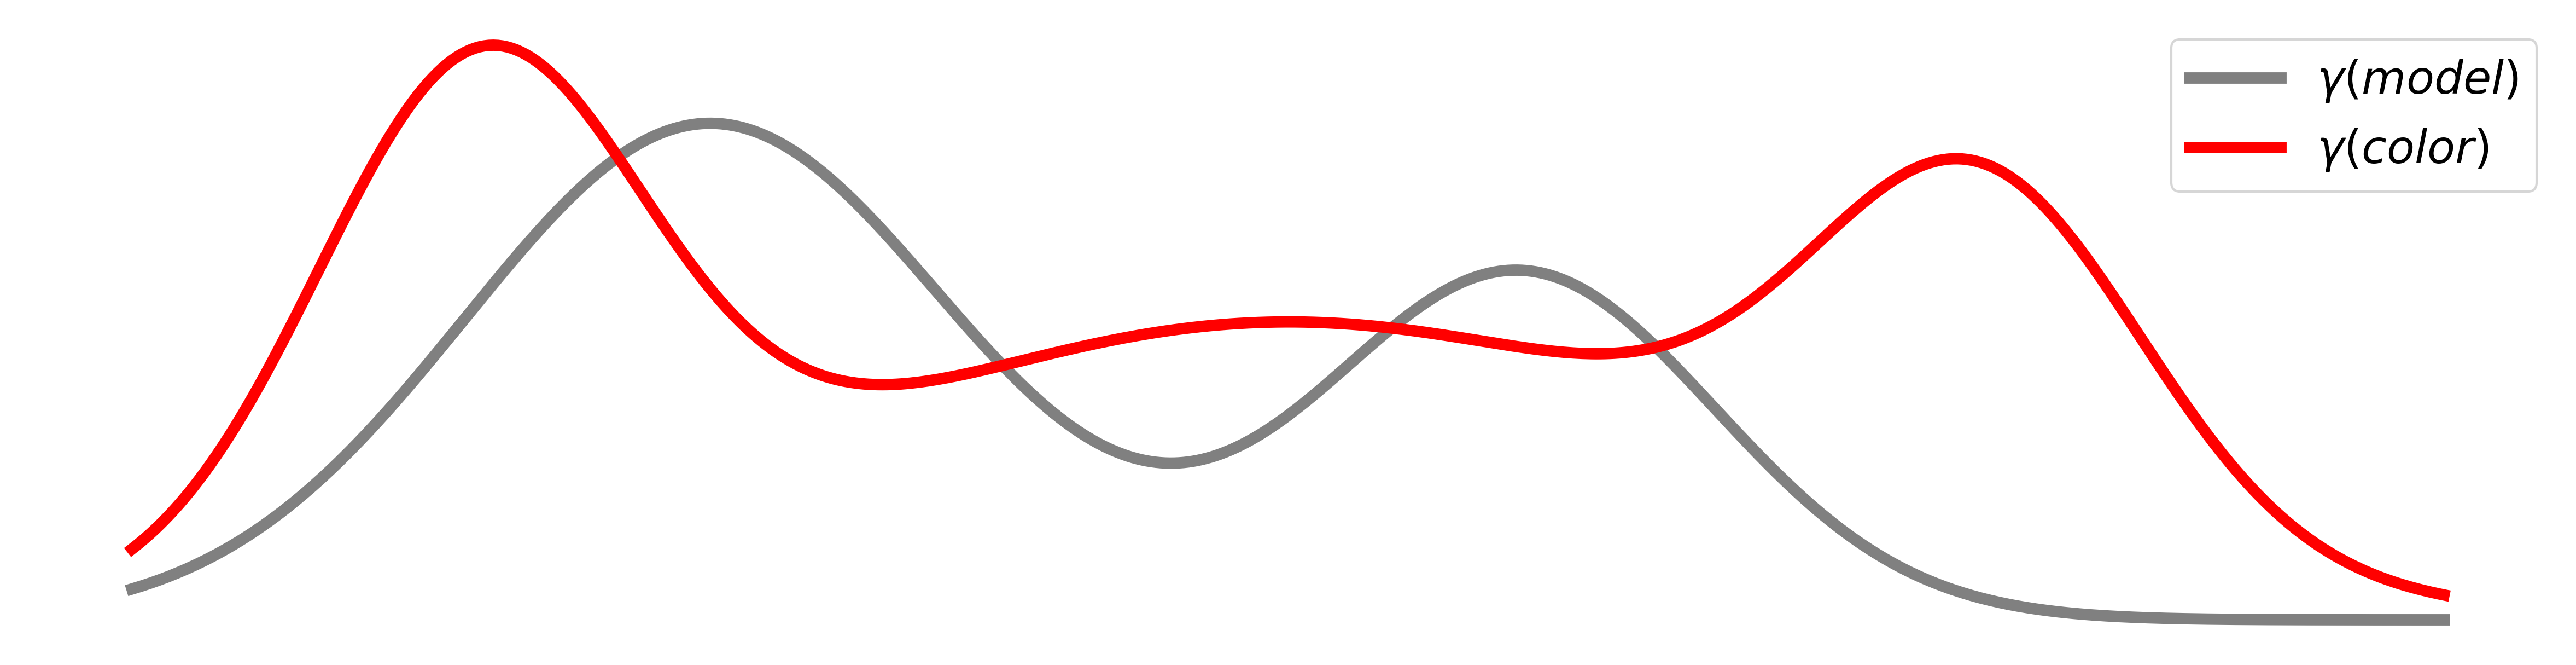

In [ ]:
def gauss(x,mu,sigma):
    return np.exp(-(x-mu)**2/(sigma**2))

x = np.linspace(0,1,500)
dist_model = gauss(x,0.25,0.15) + gauss(x,0.6,0.12)*0.7
dist_color = 0.6*gauss(x,0.5,0.3)+ gauss(x,0.15,0.1)+ gauss(x,0.8,0.1)*0.7

plt.figure(figsize=(20,5),dpi=300)
plt.axis(False)
plt.plot(x,dist_model, lw=5, label="$\gamma(model)$", color="gray")
plt.plot(x,dist_color, lw=5, label="$\gamma(color)$", color="red")
plt.legend(fontsize=20)

In [ ]:
# This function will be called every time we want to create an animation to set up figure and axis
def setup_axes():
    fig,ax = fig, ax = plt.subplots(1,1,figsize=(20,5),dpi=300)
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.set_ylim(-0.1,1.2)
    ax.set_xlim(0,1)
    return fig,ax



  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 1/499 [00:01<09:27,  1.14s/it]

  0%|          | 2/499 [00:01<05:18,  1.56it/s]

  1%|          | 3/499 [00:01<03:46,  2.19it/s]

  1%|          | 4/499 [00:01<03:02,  2.72it/s]

  1%|          | 5/499 [00:02<02:33,  3.22it/s]

  1%|          | 6/499 [00:02<02:15,  3.63it/s]

  1%|▏         | 7/499 [00:02<02:06,  3.89it/s]

  2%|▏         | 8/499 [00:02<01:57,  4.18it/s]

  2%|▏         | 9/499 [00:02<01:51,  4.39it/s]

  2%|▏         | 10/499 [00:03<01:58,  4.12it/s]

  2%|▏         | 11/499 [00:03<02:09,  3.76it/s]

  2%|▏         | 12/499 [00:03<02:18,  3.53it/s]

  3%|▎         | 13/499 [00:04<02:23,  3.38it/s]

  3%|▎         | 14/499 [00:04<02:27,  3.29it/s]

  3%|▎         | 15/499 [00:04<02:27,  3.29it/s]

  3%|▎         | 16/499 [00:05<02:28,  3.26it/s]

  3%|▎         | 17/499 [00:05<02:25,  3.30it/s]

  4%|▎         | 18/499 [00:05<02:32,  3.15it/s]

  4%|▍         | 19/499 [00:06<02:23,  3.34it/s]

  4%|▍         |

FileNotFoundError: [Errno 2] No such file or directory: 'assets'

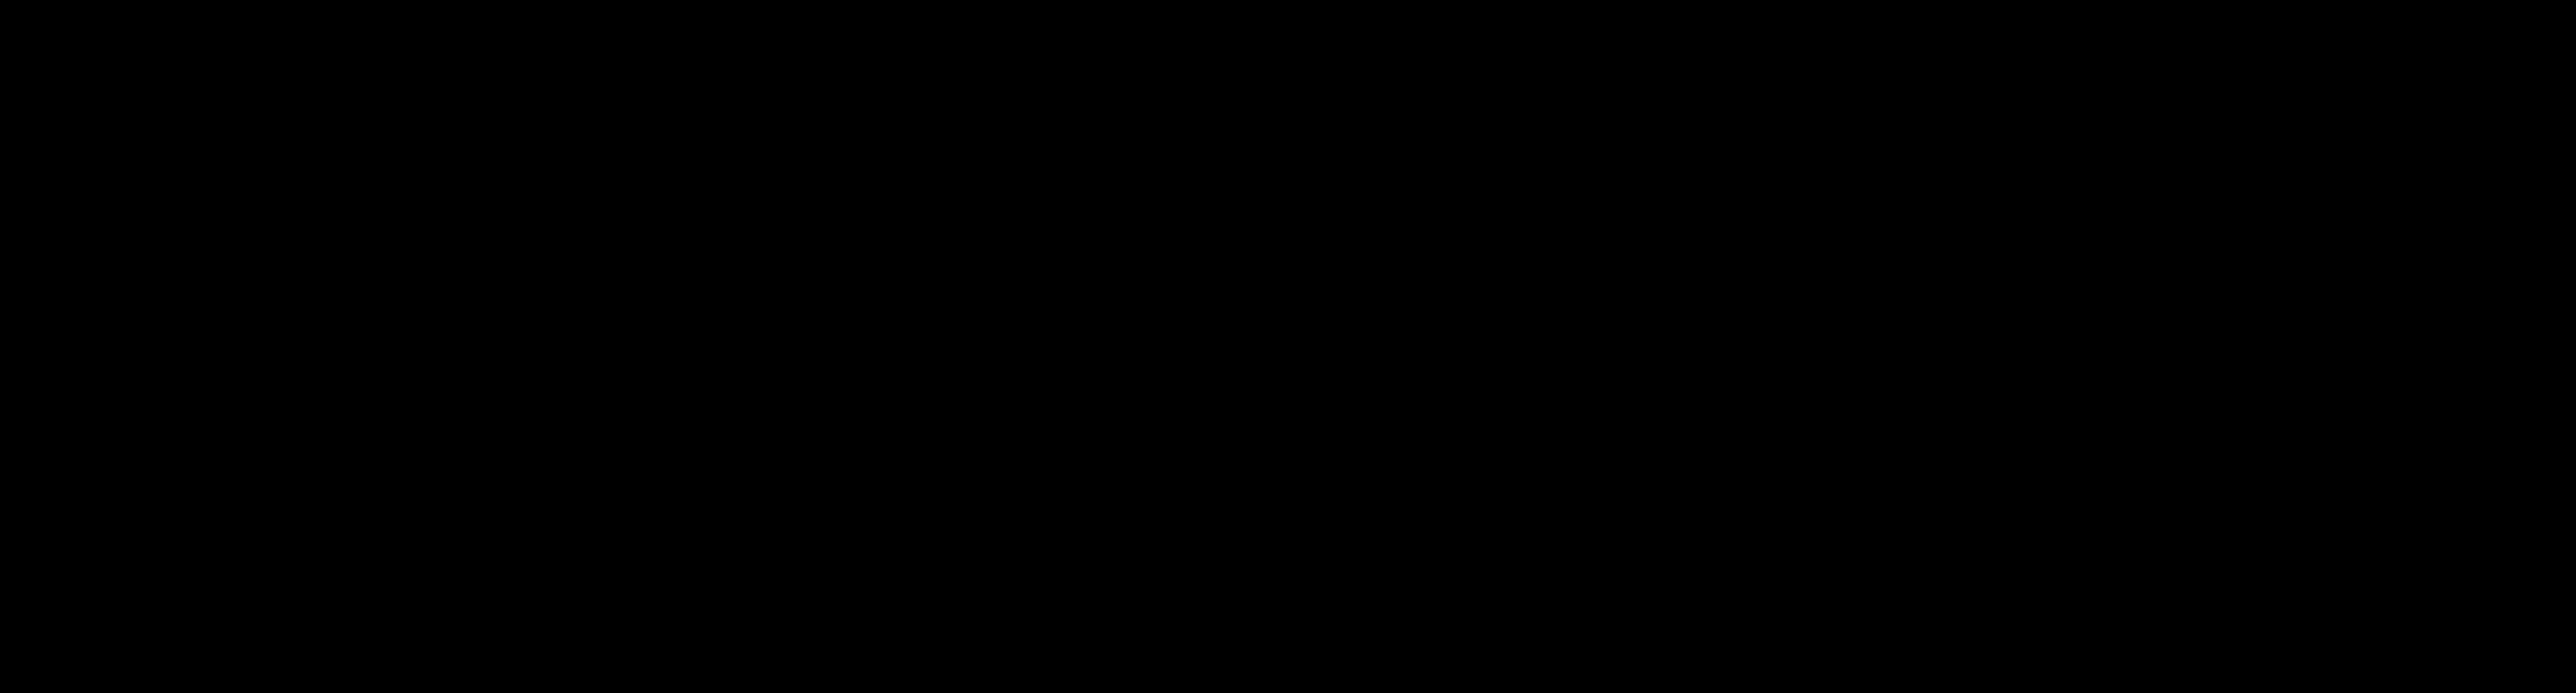

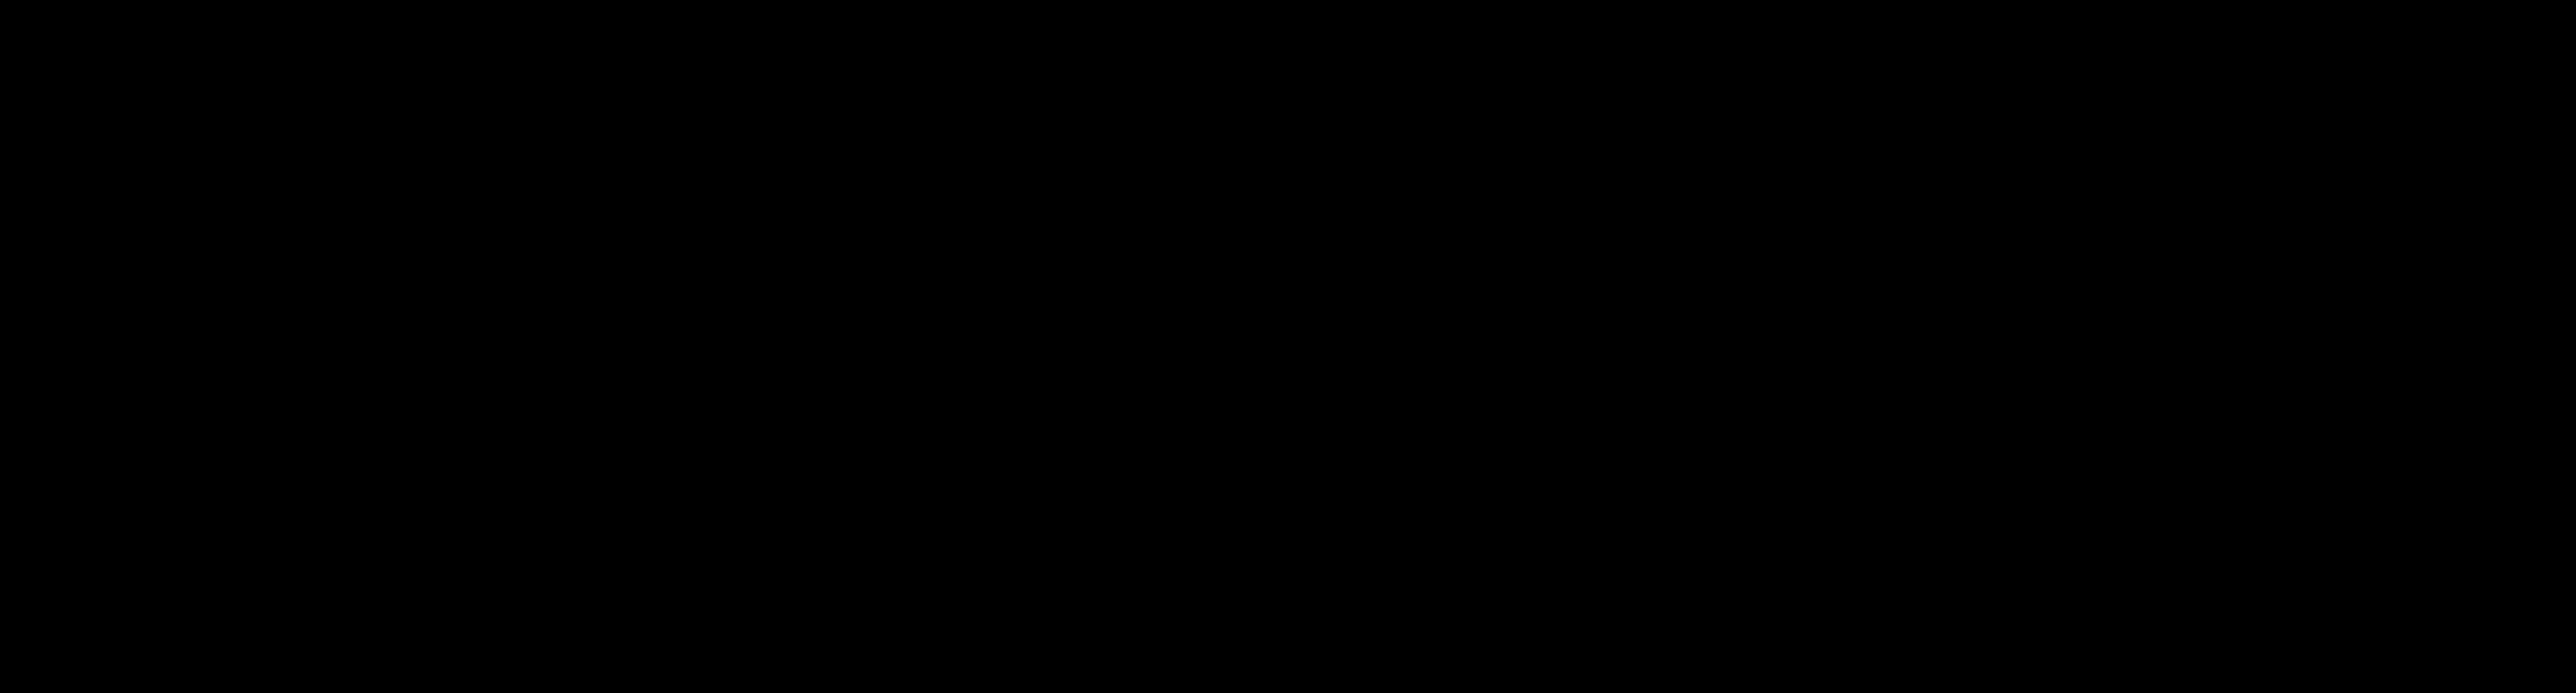

In [ ]:
#---  Color distribution
fig, ax = setup_axes()

lc = get_gradient_curve(x, dist_color, zorder=3)
ax.add_collection(lc)
animation = animate_line_collections([lc],fig)
animation.save("1D Color distribution - curve.mp4")


# --- Model distribution
fig, ax = setup_axes()

line = ax.plot(x, dist_model, lw=10, solid_capstyle="round", color="white")[0]
animation = animate_lines([line],fig)
animation.save("1D Model distribution - curve.mp4")